In this notebook we will try to build an emulator using a NN architecture.

In [ ]:
import numpy as np
import sys,os,time
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

CUDA Not Available


Let's generate a data set. We begin with a simple linear relation

In [ ]:
def target_generator(X, add_noise=False):
    target = q + m*X
    if add_noise:
        rng = np.random.RandomState(1)
        target += rng.normal(0, scatter, size=target.shape)
    return target.squeeze() # squeeze: Returns a tensor with all specified dimensions of input of size 1 removed.

In [ ]:
m=3. # slope
q=5. # intercept
scatter=0.3 # noise scatter

X = np.linspace(0, 5, num=100).reshape(-1, 1)
y = target_generator(X, add_noise=False)

# Generate n_train data point
n_train=1000
rng = np.random.RandomState(0)
X_samp = rng.uniform(0, 5, size=n_train).reshape(-1, 1)
y_samp = target_generator(X_samp, add_noise=True)

print(X_samp.shape)
print(y_samp.shape)

(1000, 1)
(1000,)


var 0.08683563235114666 std 0.2946788630885267


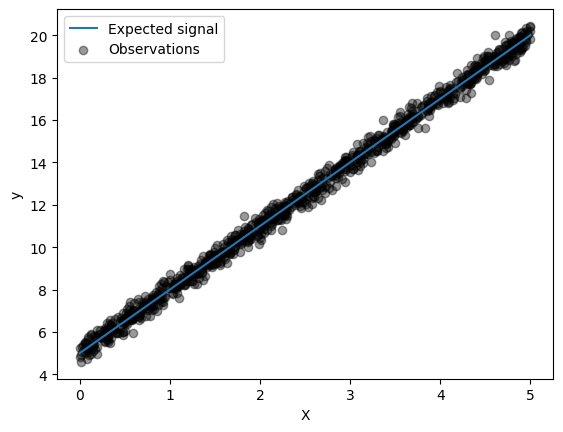

In [ ]:
plt.plot(X, y, label="Expected signal")
plt.scatter(
    x=X_samp[:, 0],
    y=y_samp,
    color="black",
    alpha=0.4,
    label="Observations",
)
plt.legend()
plt.xlabel("X")
plt.ylabel("y")

var=1./(X_samp.size-1.)*np.sum((y_samp-target_generator(X_samp, add_noise=False))**2.)
print('var',var,'std',np.sqrt(var))

The fundamental step performed by a NN are:


1.   Forward pass: Compute the loss function
2.   Compute the local gradient
3.   Backward pass: Compute derivative of loss function w.r.t. to the parameters

Let's build the simplest possibile NN with $\tt{numpy}$:
- $x → 1-\text{Neuron} → y $ (No activation function)
- Loss function = $\mathcal{L}= \frac{ \sum (\hat{y} - y(x))^2}{N}$
- Gradient:
$$\frac{d L}{d w} = \frac{1}{N} 2x \cdot (\hat{y} - y(x))$$
$$\frac{d L}{d b} = \frac{2}{N} \sum (\hat{y} - y(x))$$



In [ ]:
# model prediction
def forward(x):
    return b + w*x # (NB in this example w and b are global variables)

# loss = Mean Squared Error
def loss(y, y_predicted):
    return np.mean((y-y_predicted)**2.)

# gradient
# dLoss/dw = 1/N 2x \dot (b+w*x - y)
# dLoss/db = 1/N 2 \sum (b+w*x - y)
def gradient(x,y,y_predicted):
    dLossdw=(np.dot(2*x,y_predicted-y))/y.size
    dLossdb=np.mean(2*(y_predicted-y))
    return dLossdw,dLossdb

epoch 1 w = 0.74421, b = 0.24901, loss=174.12792128
epoch 2 w = 1.35312, b = 0.45613, loss=118.09877366
epoch 3 w = 1.85118, b = 0.62891, loss=80.46147868
epoch 4 w = 2.25840, b = 0.77354, loss=55.17544231
epoch 5 w = 2.59117, b = 0.89508, loss=38.18406618
epoch 6 w = 2.86294, b = 0.99769, loss=26.76311622
epoch 7 w = 3.08473, b = 1.08476, loss=19.08311567
epoch 8 w = 3.26557, b = 1.15910, loss=13.91546746
epoch 9 w = 3.41284, b = 1.22298, loss=10.43509890
epoch 10 w = 3.53262, b = 1.27828, loss=8.08792656
epoch 11 w = 3.62987, b = 1.32653, loss=6.50185150
epoch 12 w = 3.70866, b = 1.36900, loss=5.42698755
epoch 13 w = 3.77233, b = 1.40671, loss=4.69552131
epoch 14 w = 3.82361, b = 1.44050, loss=4.19475580
epoch 15 w = 3.86474, b = 1.47108, loss=3.84900786
epoch 16 w = 3.89757, b = 1.49901, loss=3.60745118
epoch 17 w = 3.92358, b = 1.52475, loss=3.43595220
epoch 18 w = 3.94402, b = 1.54869, loss=3.31158752
epoch 19 w = 3.95990, b = 1.57113, loss=3.21896198
epoch 20 w = 3.97204, b = 1.5

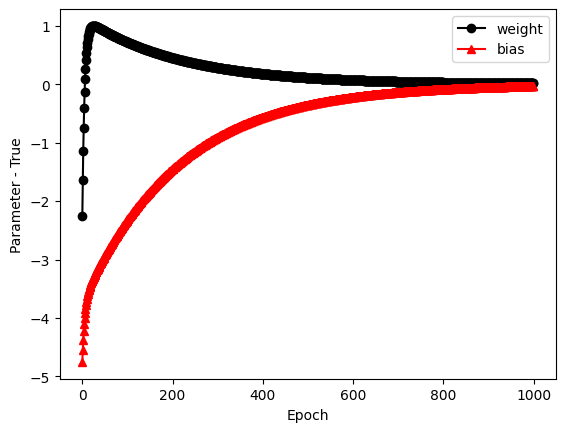

In [ ]:
# Initialize the parameters
w=0.0
b=0.0

# training:
lr=0.01 # learning rate
n_iter=1000 # number of iteration

# Define some useful array to check the behaviour of the training
w_epoch=np.zeros(n_iter)
b_epoch=np.zeros(n_iter)
loss_epoch=np.zeros(n_iter)

for epoch in range(n_iter):
    # prediction = forward pass
    y_pred = forward(X_samp[:,0])

    # print((y-y_pred).shape)

    # loss
    l = loss(y_samp, y_pred)

    # gradient
    dw, db = gradient(X_samp[:,0],y_samp,y_pred)

    # update parameters
    w  -= lr*dw  # w = w - lr*dw
    b  -= lr*db

    if epoch%1==0:
        print(f'epoch {epoch+1:} w = {w:.5f}, b = {b:.5f}, loss={l:.8f}')

    loss_epoch[epoch]=l
    w_epoch[epoch]=w
    b_epoch[epoch]=b


plt.plot(np.arange(n_iter),w_epoch-m,'o-',color='k',label='weight')
plt.plot(np.arange(n_iter),b_epoch-q,'^-',color='r',label='bias')
plt.xlabel('Epoch')
plt.ylabel('Parameter - True')
plt.legend()

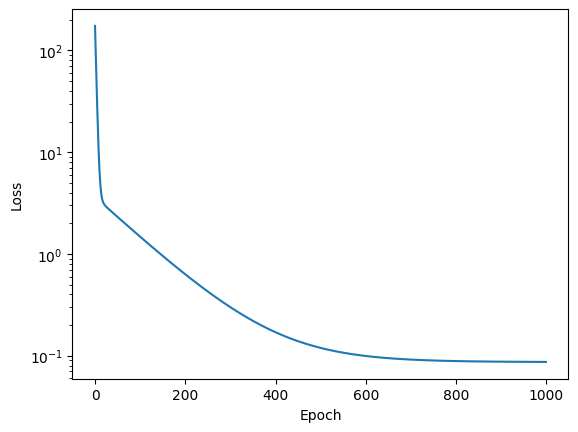

In [ ]:
plt.plot(np.arange(n_iter),loss_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')

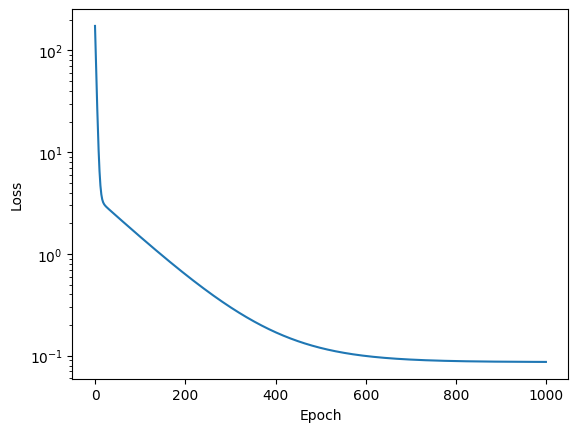

### Questions:

- Looking at the final value of the loss function, what can we argue about the accuracy of the NN? Can we further improve it?
- What happen if we try to change the learning rate? Try to repeat the example using `learning_rate=0.1` and `learning_rate=0.0001` keeping the same number of epochs

MSE for true values: 0.08674879671879551


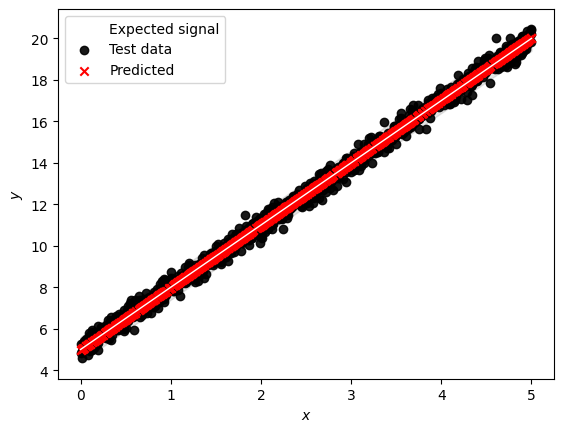

In [ ]:
# plot the prediction versus the true values
y_NN = forward(X_samp)
print('MSE for true values:',np.mean((y_samp - (q+m*X_samp[:,0]))**2.))

plt.plot(X, y, lw=1, color='white', label="Expected signal",zorder=4)
plt.fill_between(X[:,0] , y-scatter,y+scatter, color='gray', alpha=0.5)
plt.fill_between(X[:,0] , y-2.*scatter,y+2.*scatter, color='gray', alpha=0.2)
plt.scatter(X_samp,y_samp,c='k',alpha=0.9,label='Test data')
plt.scatter(X_samp,y_NN,c='r',marker='x',label='Predicted')

plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()

#### Let's try to do the same thing using pytorch built-in functions:


In [ ]:
# model prediction
def forward(x):
    return b + w*x

# loss = Mean Squared Error
def loss(y, y_predicted):
    return torch.mean((y-y_predicted)**2.)

# gradient
# dMSE/dw = 1/N 2x \dot (b+w*x - y)
# dMSE/db = 1/N 2 (b+w*x - y)
def gradient(x,y,y_predicted):
    dJdw=(torch.dot(2*x,y_predicted-y))/y.size
    dJdb=torch.mean(2*(y_predicted-y))
    return dJdw,dJdb

In [ ]:
# Transform the input and ouput data in torch tensor
X_torch=torch.tensor(X_samp, dtype=torch.float32)
y_torch=torch.tensor(y_samp, dtype=torch.float32)

# same thing for the parameters we want to optimize
w=torch.tensor(0.0, dtype=torch.float32, requires_grad=True)
b=torch.tensor(0.0, dtype=torch.float32, requires_grad=True)


# prediction before training:
print(f'Prediction before training: f(5)={forward(5):.3f}')

# training:
lr=0.1 # learning rate
n_iter=100

# Optimizer function to update the weights:
optimizer = torch.optim.SGD([w,b], lr=lr) # Implements stochastic gradient descent

for epoch in range(n_iter):
    # prediction = forward pass
    y_pred = forward(X_torch[:,0])

    # print((y-y_pred).shape)

    # loss
    l = loss(y_torch, y_pred)

    # gradient = backward pass
    l.backward() # d loss / dw and d loss / db

    # # As before we can update the parameters manually
    # with torch.no_grad(): # to tell pytorch to compute this block without storing the gradient
    #     # update parameters
    #     w  -= lr*w.grad
    #     b  -= lr*b.grad
    #     # we MUST also empty (put zero) the gradients, otherwise they cumulate in w.grad and b.grad
    # w.grad.zero_()
    # b.grad.zero_()

    # # The same operation can be done using the optimazier defined above
    optimizer.step() # update the parameters
    optimizer.zero_grad() # zero the gradients

    if epoch%1==0:
        print(f'epoch {epoch+1:} w = {w:.5f}, b = {b:.5f}, loss={l:.8f}')

# prediction after training:
print(f'Prediction after training: f(5)={forward(5):.3f}')

Prediction before training: f(5)=0.000
epoch 1 w = 7.44205, b = 2.49009, loss=174.12791443
epoch 2 w = 1.35547, b = 0.79149, loss=113.83608246
epoch 3 w = 6.16586, b = 2.45108, loss=74.66661835
epoch 4 w = 2.20680, b = 1.39317, loss=49.19771576
epoch 5 w = 5.31247, b = 2.51023, loss=32.61738968
epoch 6 w = 2.73382, b = 1.86371, loss=21.80557060
epoch 7 w = 4.73554, b = 2.62530, loss=14.73906517
epoch 8 w = 3.05287, b = 2.24188, loss=10.10576725
epoch 9 w = 4.34000, b = 2.76961, loss=7.05461264
epoch 10 w = 3.23917, b = 2.55348, loss=5.03344584
epoch 11 w = 4.06402, b = 2.92651, loss=3.68392944
epoch 12 w = 3.34128, b = 2.81587, loss=2.77340698
epoch 13 w = 3.86732, b = 3.08577, loss=2.15073180
epoch 14 w = 3.39053, b = 3.04082, loss=1.71761715
epoch 15 w = 3.72366, b = 3.24132, loss=1.41008031
epoch 16 w = 3.40705, b = 3.23650, loss=1.18639660
epoch 17 w = 3.61584, b = 3.38967, loss=1.01929283
epoch 18 w = 3.40377, b = 3.40865, loss=0.89088798
epoch 19 w = 3.53261, b = 3.52901, loss=0.

### Let's make thinkg more properly.
A NN pipeline looks like:


1.   Designing a model (input, output, forward pass)
2.   Construct loss and optimazier
3.   Training loop:


> *   forward pass: compute predictions
*   backward pass: compute gradients
*   update weights

**Define the (Hyper)-parameters used by the NN**

In [ ]:
seed           = 1                         #random seed to shuffle data before splitting into training, validation and testing
min_valid_loss_param = 1e100                       #set this to a large number. Used later as threshold to save trained model
batch_size     = 32                        #number of elements each batch contains. Hyper-parameter
lr             = 1e-2                      #value of the learning rate. Hyper-parameter
wd             = 0.0                       #value of the weight decay. Hyper-parameter
epochs         = 500                       #number of epochs to train the network. Hyper-parameter

f_model = 'best_model.pt'                  # Where to save the trained model

In [ ]:
def create_dataset(mode, x, y, batch_size, seed):

    # create the class with the dataset
    data_set = make_dataset(mode, x, y, seed)

    # create the data loader
    return DataLoader(dataset=data_set, batch_size=batch_size, shuffle=True)

In [ ]:
# This class creates the dataset
class make_dataset():

    def __init__(self, mode, x, y, seed):

        # get the number of training data
        n_training = x.shape[0]

        # get the size and offset depending on the type of dataset
        if   mode=='train':
            size, offset = int(n_training*0.70), int(n_training*0.00)
        elif mode=='valid':
            size, offset = int(n_training*0.15), int(n_training*0.70)
        elif mode=='test':
            size, offset = int(n_training*0.15), int(n_training*0.85)
        elif mode=='all':
            size, offset = int(n_training*1.00), int(n_training*0.00)
        else:    raise Exception('Wrong name!')

        # define size, input and output arrays containing the data
        self.size   = size
        self.input  = torch.zeros((size,1), dtype=torch.float) #array with x values
        self.output = torch.zeros((size,1),    dtype=torch.float) #array with y values

        # randomly shuffle the data. Instead of 0 1 2 3...999 have a
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        indexes = np.arange(n_training)
        np.random.shuffle(indexes) # Modify a sequence in-place by shuffling its contents
        indexes = indexes[offset:offset+size] #select indexes of the mode ('train', 'valid', 'test')

        # get the corresponding x and y values
        self.input  = torch.tensor(x[indexes], dtype=torch.float32)
        self.output = torch.tensor(y[indexes], dtype=torch.float32)
        self.output = self.output.unsqueeze(1) # torch reuiqres [n,1] tensors
        # self.output = self.output.view(self.output.shape[0],1) # same as unsqueeze

    # This protocol returns the size of the dataset
    def __len__(self):
        return self.size

    # This protocol returns the datasets
    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

In [ ]:
# get the data for training and validation
train_loader = create_dataset('train', X_samp, y_samp, batch_size, seed) #training data
valid_loader = create_dataset('valid', X_samp, y_samp, batch_size, seed) #validation data

**Create the NN model. Since we know that we are fitting a linear model the NN can be simply a linear regressor**

In [ ]:
model = nn.Linear(1,1,bias=True) # we have 1 input, the x value, and 1 ouput, y

#move it to the GPU
model.to(device=device)                   #move the architecture to the GPU, if available

# compute the number of parameters in the model
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

[w,b]=model.parameters()
print(f'Starting params: w=[ {w[0][0]:.4f},], b= [{b[0]:.4f}]')

total number of parameters in the model = 2
Starting params: w=[ -0.6647,], b= [0.6207]


In [ ]:
# Define the loss function and the optimazier

# def loss_func(y_predicted, y_training): # simple MSE
#     return torch.mean((y_training-y_predicted)**2)

loss_func= nn.MSELoss()

# optimizer = torch.optim.SGD(model.parameters(), lr=lr) # SGD = Stochastic Gradient Discendent

optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=wd)

In [ ]:
start = time.time()

train_value=np.zeros(epochs)
valid_value=np.zeros(epochs)

min_valid_loss=min_valid_loss_param

# do a loop over all epochs
for epoch in range(epochs):

    # do training
    train_loss, points = 0.0, 0
    model.train()  #set this when training. Some architecture pieces, e.g. dropout behave differently
    for x_train, y_train in train_loader:  #do a loop over all the batches in the training set

        # get the size of the batch
        bs = x_train.shape[0]

        # move data to GPU
        y_train = y_train.to(device)
        x_train   = x_train.to(device)

        # compute the value predicted by the network
        y_pred  = model(x_train)

        # compute loss
        loss = loss_func(y_pred, y_train)

        # compute cumulative loss and number of examples used
        train_loss += (loss.item())*bs # .item() to get only the scalar value from a single-element tensor
        points     += bs

        # zero gradients and do backpropagation. This is the magic!
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # get the average training loss
    train_loss /= points
    train_value[epoch]=train_loss


    # do validation
    valid_loss, points = 0.0, 0
    model.eval()   #set this for validation and testing. Some architecture pieces, e.g. dropout behave differently
    for x_val, y_val in valid_loader: # do a loop over all batches in the validation set
        with torch.no_grad():   #put this for validation/testing, so save memory and be more efficient. It tells to dont save gradients.

            # get the size of the batch
            bs = x_val.shape[0]

            # move data to the GPU
            y_val = y_val.to(device)
            x_val   = x_val.to(device)

            # compute prediction by the network
            y_pred  = model(x_val)

            # compute cumulative loss and number of examples used
            valid_loss += (loss_func(y_pred, y_val).item())*bs
            points     += bs

    # get the average validation loss
    valid_loss /= points
    valid_value[epoch]=valid_loss

    # if epoch%10==0:
    #     print('Epoch: %03d '%(epoch), end='')
    # save model if it has a lower validation loss
    if valid_loss<min_valid_loss:
        torch.save(model.state_dict(), f_model)
        min_valid_loss = valid_loss
        print(f'Best model Epoch: {epoch}: w=[ {w[0][0]:.4f}], b= [{b[0]:.4f}]')
    # else:
    #     print('')

print(f'Best model Loss (validation):{min_valid_loss:.4f}')
stop = time.time()
print('Time taken (seconds):', "{:.4f}".format(stop-start))

Best model Epoch: 0: w=[ -0.4462], b= [0.8389]
Best model Epoch: 1: w=[ -0.2394], b= [1.0486]
Best model Epoch: 2: w=[ -0.0369], b= [1.2531]
Best model Epoch: 3: w=[ 0.1577], b= [1.4506]
Best model Epoch: 4: w=[ 0.3456], b= [1.6411]
Best model Epoch: 5: w=[ 0.5283], b= [1.8258]
Best model Epoch: 6: w=[ 0.7026], b= [2.0029]
Best model Epoch: 7: w=[ 0.8714], b= [2.1736]
Best model Epoch: 8: w=[ 1.0333], b= [2.3374]
Best model Epoch: 9: w=[ 1.1862], b= [2.4934]
Best model Epoch: 10: w=[ 1.3337], b= [2.6432]
Best model Epoch: 11: w=[ 1.4749], b= [2.7861]
Best model Epoch: 12: w=[ 1.6061], b= [2.9208]
Best model Epoch: 13: w=[ 1.7324], b= [3.0495]
Best model Epoch: 14: w=[ 1.8509], b= [3.1709]
Best model Epoch: 15: w=[ 1.9635], b= [3.2858]
Best model Epoch: 16: w=[ 2.0686], b= [3.3938]
Best model Epoch: 17: w=[ 2.1667], b= [3.4950]
Best model Epoch: 18: w=[ 2.2591], b= [3.5900]
Best model Epoch: 19: w=[ 2.3440], b= [3.6784]
Best model Epoch: 20: w=[ 2.4233], b= [3.7609]
Best model Epoch: 21

[]

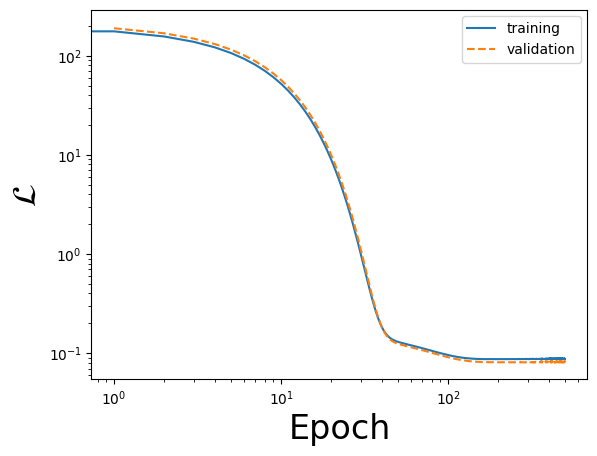

In [ ]:
# Check the evolution of loss function
epoche=np.arange(epochs)

plt.plot(epoche,train_value,label='training')
plt.plot(epoche+1,valid_value,ls='--',label='validation')

plt.legend()
plt.xlabel("Epoch", fontsize=24)
plt.ylabel("$\mathcal{L}$", fontsize=24)
plt.loglog()

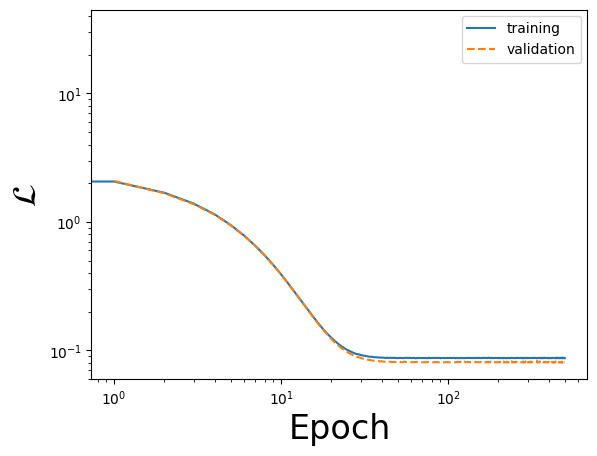

#### Exercise: Try to repeat the training using the Adam optimizer:



```
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=wd)
```
Adam (Adaptive Moment Estimation: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) adjusts learning rates individually for each parameter,
allowing for efficient optimization and convergence.
`betas` and `weight_decay` are hyperparameters that control the optimization
process of the Adam optimizer. `betas` control the decay rates of the moving
averages of the gradient and its square, while `weight_decay` controls
the amount of L2 regularization applied to the model weights during optimization

```cost = loss + weight_decay*\sum |w|^2)```


Test the best model

In [ ]:
# get the test data
test_loader = create_dataset('test', X_samp, y_samp, batch_size, seed) #test data

# load the best-model and move it to the GPU
model.load_state_dict(torch.load(f_model))
model.to(device=device)

# # Print best-model parameters
[w,b]=model.parameters()
print(f'Best fit model parameters: w=[ {w[0][0]:.4f}], b= [{b[0]:.4f}]')

# define arraies where to store stuff

x_values=np.zeros((int(X_samp.shape[0]*0.15),1), dtype=np.float32)
y_true = np.zeros((int(y_samp.shape[0]*0.15),1), dtype=np.float32)
y_NN = np.zeros((int(y_samp.shape[0]*0.15),1), dtype=np.float32)

# loop over the different batches and get the prediction
offset = 0
test_loss, points = 0.0, 0
model.eval()

counter=0
for x_test, y_test in test_loader:
    with torch.no_grad():

        bs=x_test.shape[0]

        # move data to GPU
        x_test   = x_test.to(device)
        y_test = y_test.to(device)

        # make prediction using network
        y_pred  = model(x_test)

        # Store predictions and true parameter values
        # Need to move the array to cpu() and make it numpy()
        x_values[counter:counter+bs,:]=x_test
        y_true[counter:counter+bs,:]= y_test.cpu().numpy()
        y_NN[counter:counter+bs,:]= y_pred.cpu().numpy()

        # compute cumulative loss and number of examples used
        test_loss += (loss_func(y_pred, y_test).item())*x_test.shape[0]
        points += x_test.shape[0]

        counter += bs

# get the average validation loss
test_loss /= points

print('test loss = %.3e'%test_loss)

Best fit model parameters: w=[ 3.0006], b= [5.0075]
test loss = 9.094e-02


<ipython-input-36-4a053f333809>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f_model))


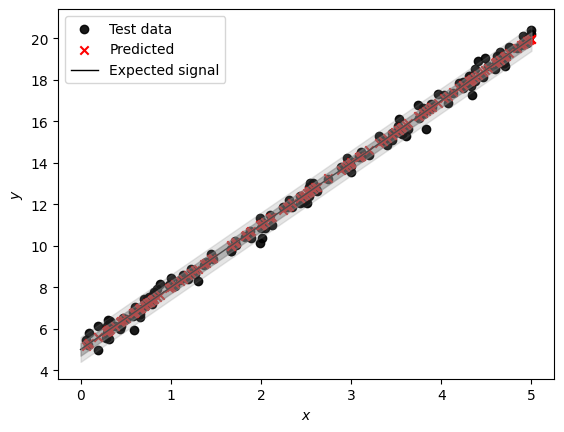

In [ ]:
# plot the prediction versus the true values
plt.scatter(x_values,y_true,c='k',alpha=0.9,label='Test data')
plt.scatter(x_values,y_NN,c='r',marker='x',label='Predicted')
plt.plot(X, y, lw=1, color='k', label="Expected signal",zorder=1)
plt.fill_between(X[:,0] , y-0.3,y+0.3, color='gray', alpha=0.5)
plt.fill_between(X[:,0] , y-2.*0.3,y+2.*0.3, color='gray', alpha=0.2)

plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()

### Let's try to predict also the error on $y$

In [ ]:
# Set hyper-params and model
seed           = 1                         #random seed to shuffle data before splitting into training, validation and testing
min_valid_loss_param = 1e100                       #set this to a large number. Used later as threshold to save trained model
batch_size     = 128                        #number of elements each batch contains. Hyper-parameter
lr             = 1e-1                      #value of the learning rate. Hyper-parameter
wd             = 0.0                       #value of the weight decay. Hyper-parameter
epochs         = 500                       #number of epochs to train the network. Hyper-parameter

f_model = 'best_model.pt'                  # Where to save the trained model

model = nn.Linear(1,2,bias=True) # we have 1 input, the x value, and 2 ouput, y and \sigma_y

#move it to the GPU
model.to(device=device)                   #move the architecture to the GPU, if available

# compute the number of parameters in the model
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

[w,b]=model.parameters()
print(f'Starting params: w=[ {w[0][0]:.4f},{w[1][0]:.4f}], b= [{b[0]:.4f},{b[1]:.4f}]')

# get the data for training and validation
train_loader = create_dataset('train', X_samp, y_samp, batch_size, seed) #training data
valid_loader = create_dataset('valid', X_samp, y_samp, batch_size, seed) #validation data

We need to define a Loss function which rewards values of the scatter close to that of the data

\begin{equation}
 \sum_{i \in {\rm batch}} (y_i-\hat{y}_i)^2 + ((y_i-\hat{y}_i)^2 - \sigma_i^2)^2
\end{equation}

or

\begin{equation}
 \log\sum_{i \in {\rm batch}} (y_i-\hat{y}_i)^2 + \log \sum_{i \in {\rm batch}} ((y_i-\hat{y}_i)^2 - \sigma_i^2)^2
\end{equation}

In [ ]:
class loss_function(nn.Module):
    def __init__(self):
        super(loss_function, self).__init__()
    def forward(self, y_sig_predicted,y_training):
        return torch.sum((y_training[:,0]-y_sig_predicted[:,0])**2.+((y_training[:,0]-y_sig_predicted[:,0])**2. - y_sig_predicted[:,1]**2.)**2.)  # From https://arxiv.org/abs/2009.08459
        # return torch.log(torch.sum((y_training[:,0]-y_sig_predicted[:,0])**2)) + torch.log(torch.sum(((y_training[:,0]-y_sig_predicted[:,0])**2. - y_sig_predicted[:,1]**2.)**2.))  # From https://arxiv.org/pdf/2109.10915.pdf

loss_func = loss_function()

optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=wd)


In [ ]:
start = time.time()

train_value=np.zeros(epochs)
valid_value=np.zeros(epochs)

min_valid_loss=min_valid_loss_param

# do a loop over all epochs
for epoch in range(epochs):

    # do training
    train_loss, points = 0.0, 0
    model.train()  #set this when training. Some architecture pieces, e.g. dropout behave differently
    for x_train, y_train in train_loader:  #do a loop over all elements in the training set

        # get the size of the batch
        bs = x_train.shape[0]

        # move data to GPU
        y_train = y_train.to(device)
        x_train   = x_train.to(device)

        # compute the values predicted by the network
        y_sig_pred  = model(x_train) # Now we have 2 ouput values

        # y_pred= y_sig_pred[:,0]
        # sig_pred= y_sig_pred[:,1]

        # compute loss
        loss = loss_func(y_sig_pred, y_train)

        # compute cumulative loss and number of examples used
        train_loss += (loss.item())
        points     += bs

        # zero gradients and do backpropagation. This is the magic!
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    # get the average training loss
    train_loss /= points
    train_value[epoch]=train_loss


    # do validation
    valid_loss, points = 0.0, 0
    model.eval()   #set this for validation and testing. Some architecture pieces, e.g. dropout behave differently
    for x_val, y_val in valid_loader: # do a loop over all elements in the validation set
        with torch.no_grad():   #put this for validation/testing, so save memory and be more efficient. It tells to dont save gradients.

            # get the size of the batch
            bs = x_val.shape[0]

            # move data to the GPU
            y_val = y_val.to(device)
            x_val   = x_val.to(device)

            # compute prediction by the network
            y_sig_pred  = model(x_val)

            # compute cumulative loss and number of examples used
            valid_loss += (loss_func(y_sig_pred, y_val).item())
            points     += bs

    # get the average validation loss
    valid_loss /= points
    valid_value[epoch]=valid_loss

    print('Epoch: %03d '%(epoch), train_value[epoch] , valid_value[epoch] )

    # if epoch%10==0:
        # [w,b]=model.parameters()
        # print('Epoch: %03d '%(epoch), end='')
        # print(f'Epoch: {epoch}: w=[ {w[0][0]:.4f},{w[1][0]:.4f}], b= [{b[0]:.4f},{b[1]:.4f}]')
    # save model if it has a lower validation loss
    if valid_loss<min_valid_loss:
        torch.save(model.state_dict(), f_model)
        min_valid_loss = valid_loss
        # [w,b]=model.parameters()
        print(f'Best model Epoch: {epoch}: w=[ {w[0][0]:.4f},{w[1][0]:.4f}], b= [{b[0]:.4f},{b[1]:.4f}]')
    # else:
    #     print('')

print(f'Best model Loss (validation):{min_valid_loss:.4f}')
stop = time.time()
print('Time taken (seconds):', "{:.4f}".format(stop-start))

In [ ]:
epoche=np.arange(epochs)

plt.plot(epoche[:],train_value[:],label='training')
plt.plot(epoche[:]+1,valid_value[:],ls='--',label='validation')

plt.legend()
plt.xlabel("Epoch", fontsize=24)
plt.ylabel("$\mathcal{L}$", fontsize=24)
plt.loglog()

### Let's test the best model

In [ ]:
# get the test data
test_loader = create_dataset('test', X_samp, y_samp, batch_size, seed) #test data

# load the best-model and move it to the GPU
model.load_state_dict(torch.load(f_model))
model.to(device=device)

# # Print best-model parameters
[w,b]=model.parameters()
print(f'Best fit model parameters: w=[ {w[0][0]:.4f},{w[1][0]:.4f}], b= [{b[0]:.4f},{b[1]:.4f}]')

# define arraies where to store stuff

x_values=np.zeros((int(X_samp.shape[0]*0.15),1), dtype=np.float32)
y_true = np.zeros((int(y_samp.shape[0]*0.15),1), dtype=np.float32)
y_sig_NN = np.zeros((int(y_samp.shape[0]*0.15),2), dtype=np.float32)

# loop over the different batches and get the prediction
offset = 0
test_loss, points = 0.0, 0
model.eval()

counter=0
for x_test, y_test in test_loader:
    with torch.no_grad():

        bs=x_test.shape[0]

        # move data to GPU
        x_test   = x_test.to(device)
        y_test = y_test.to(device)

        # make prediction using network
        y_sig_pred  = model(x_test)

        y_pred= y_sig_pred[:,0]
        sig_pred= y_sig_pred[:,1]

        # Store predictions and true parameter values
        # Need to move the array to cpu() and make it numpy()
        # print(y_true.shape,y_test.cpu().numpy().shape,y_test.cpu().numpy())
        # print(y_NN.shape,y_pred.cpu().numpy().shape,y_pred.cpu().numpy())
        x_values[counter:counter+bs,:]=x_test
        y_true[counter:counter+bs,:]= y_test.cpu().numpy()
        y_sig_NN[counter:counter+bs,:]= y_sig_pred.cpu().numpy()

        # compute cumulative loss and number of examples used
        test_loss += (loss_func(y_sig_pred, y_test).item())
        points += x_test.shape[0]

        counter += bs

# get the average validation loss
test_loss /= points

print('test loss = %.3e'%test_loss)

In [ ]:
# plot the prediction versus the true values
plt.scatter(x_values,y_true,c='k',alpha=0.9,label='Test data')
plt.scatter(x_values,y_sig_NN[:,0],c='r',marker='x',label='Predicted')
plt.plot(X, y, lw=1, color='k', label="Expected signal",zorder=1)
plt.fill_between(X[:,0] , y-0.3,y+0.3, color='gray', alpha=0.5)
plt.fill_between(X[:,0] , y-2.*0.3,y+2.*0.3, color='gray', alpha=0.2)

x_sorted=np.sort(x_values[:,0])
y_NN_sorted=y_sig_NN[x_values[:,0].argsort(),0]
sig_NN_sorted=y_sig_NN[x_values[:,0].argsort(),1]

plt.fill_between(x_sorted,y_NN_sorted-sig_NN_sorted,y_NN_sorted+sig_NN_sorted,alpha=0.9,facecolor='white',edgecolor='C0',hatch='//',zorder=0)
plt.fill_between(x_sorted,y_NN_sorted-2.*sig_NN_sorted,y_NN_sorted+2.*sig_NN_sorted,alpha=0.2,color='C0',hatch='//')

plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()

In [ ]:
plt.plot(x_sorted,np.abs(sig_NN_sorted),label='predicted')
plt.axhline(scatter,ls='--',color='gray',label='True')
plt.scatter(x_values[:,0],np.abs(y_true[:,0]-y_sig_NN[:,0]),c='k',alpha=0.9,label='$|y_{\\rm true}-y_{\\rm NN}|$')
print(x_values[:,0].size,y_true.size,y_sig_NN[:,0].size)
plt.xlabel('x')
plt.ylabel('$\sigma$')
plt.legend()

### Q: What can we do to improve the fit?

Try to change the definition of the loss function

Try to increase the number of training point

Try to change the Hyper-parameters

In [ ]:
# Generate n_train data point
n_train=1000
X_samp = rng.uniform(0, 5, size=n_train).reshape(-1, 1)
y_samp = target_generator(X_samp, add_noise=True)

# get the data for training and validation
train_loader = create_dataset('train', X_samp, y_samp, batch_size, seed) #training data
valid_loader = create_dataset('valid', X_samp, y_samp, batch_size, seed) #validation data

# Set Hyper-parameters
lr             = 1e-1                      #value of the learning rate. Hyper-parameter
wd             = 0.00                       #value of the weight decay. Hyper-parameter
epochs         = 1000                       #number of epochs to train the network. Hyper-parameter

### Let's try now to generate a non-linear model

In [ ]:
def target_generator(X, add_noise=False):
    target = X * np.sin(3 * X)
    if add_noise:
        rng = np.random.RandomState(1)
        target += rng.normal(0, 0.3, size=target.shape)
    return target.squeeze()

In [ ]:
X = np.linspace(0, 5, num=1000).reshape(-1, 1)
y = target_generator(X, add_noise=False)

n_train=1000
rng = np.random.RandomState(0)
X_samp = rng.uniform(0, 5, size=n_train).reshape(-1, 1)
y_samp = target_generator(X_samp, add_noise=True)

In [ ]:
plt.plot(X, y, label="Expected signal")
plt.scatter(
    x=X_samp[:, 0],
    y=y_samp,
    color="black",
    alpha=0.4,
    label="Observations",
)
plt.legend()
plt.xlabel("X")
plt.ylabel("y")

### Let's define the (Hyper)-parameters used by the NN

In [ ]:
seed           = 1                         #random seed to shuffle data before splitting into training, validation and testing
min_valid_loss_param = 1e10                       #set this to a large number. Used to later as threshold to save trained model
batch_size     = 32                        #number of elements each batch contains. Hyper-parameter
lr             = 1e-2                      #value of the learning rate. Hyper-parameter
wd             = 0.0                       #value of the weight decay. Hyper-parameter
dr             = 0.2                       #dropout rate. Hyper-parameter
epochs         = 5000                       # max number of epochs to train the network. Hyper-parameter
patience       = 100                        # Number of epochs without improving the loss function to wait before updating the learning rate
stop_criterion = 200                        # Number of epochs without improving the loss function to wait before stopping the training
hidden_size    = 100                       #size of hidden layer (see nn.Linear)

f_model = 'best_model.pt'                  # Where to save the trained model

In [ ]:
def create_dataset(mode, x, y, batch_size, seed):

    # create the class with the dataset
    data_set = make_dataset(mode, x, y, seed)

    # create the data loader
    return DataLoader(dataset=data_set, batch_size=batch_size, shuffle=True)

### To improve the performance and training stability is good practice to normalize or standardize the data. Normalization and standardization transform the coordinate system so that all variables have a similar scale, hence, the coefficients of linear models become interpretable.


1. #### Normalization:

\begin{equation}
\bar{x} = \frac{x - {\rm min}(x)}{{\rm max}(x) - {\rm min}(x)}
\end{equation}

*   Normalization makes training less sensitive to the scale of features, so we can better solve for coefficients.

*   Normalizing will ensure that a convergence problem does not have a massive variance, making optimization feasible


2. #### Standardization:
\begin{equation}
\hat{x} = \frac{x - {\rm mean}(x)}{{\rm std}(x)}
\end{equation}


*   Compare features that have different units or scales.
*   Standardizing tends to make the training process well behaved in particular if our features are normally distributed



In [ ]:
# This class creates the dataset
class make_dataset():

    def __init__(self, mode, x, y, seed):

        # # Normalize the value of the input
        min_x = np.min(x, axis=0)
        max_x = np.max(x, axis=0)
        x     = (x - min_x)/(max_x - min_x)

        # # Standardize the value of the ouput
        mean = np.mean(y, axis=0)
        std  = np.std(y,  axis=0)
        y = (y - mean)/std


        # get the number of training data
        n_training = x.shape[0]

        # get the size and offset depending on the type of dataset
        if   mode=='train':
            size, offset = int(n_training*0.70), int(n_training*0.00)
        elif mode=='valid':
            size, offset = int(n_training*0.15), int(n_training*0.70)
        elif mode=='test':
            size, offset = int(n_training*0.15), int(n_training*0.85)
        elif mode=='all':
            size, offset = int(n_training*1.00), int(n_training*0.00)
        else:    raise Exception('Wrong name!')

        # define size, input and output arrays containing the data
        self.size   = size
        self.input  = torch.zeros((size,1), dtype=torch.float) #array with x values
        self.output = torch.zeros((size,1),    dtype=torch.float) #array with y values

        # randomly shuffle the data. Instead of 0 1 2 3...999 have a
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        indexes = np.arange(n_training)
        np.random.shuffle(indexes)
        indexes = indexes[offset:offset+size] #select indexes of the mode

        # get the corresponding x and y values
        self.input  = torch.tensor(x[indexes], dtype=torch.float32)
        self.output = torch.tensor(y[indexes], dtype=torch.float32)
        self.output = self.output.unsqueeze(1)

        # self.output = self.output.view(self.output.shape[0],1) # same as unsqueeze

    # This protocol returns the size of the dataset
    def __len__(self):
        return self.size

    # This protocol returns
    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

In [ ]:
# get the data for training and validation
train_loader = create_dataset('train', X_samp, y_samp, batch_size, seed) #training data
valid_loader = create_dataset('valid', X_samp, y_samp, batch_size, seed) #validation data

### Lets define the architecture of the neural network
This time we need a NN which apply a non-linear transformation to fit the data.
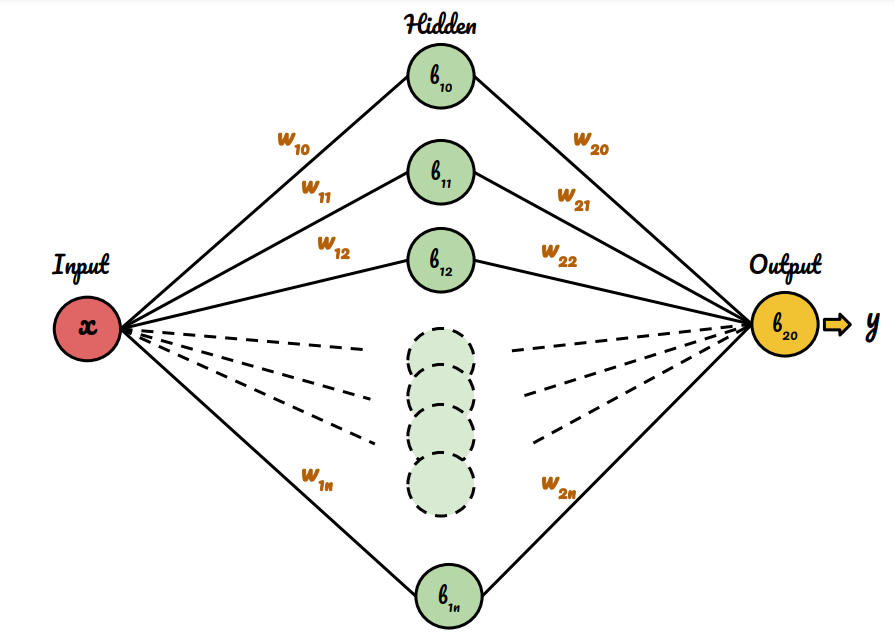

Use a python class and define the layers in the `__init__()` protocol and the model in the `forward()` routine.

In [ ]:
class one_hidden_layer(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(one_hidden_layer, self).__init__()

        # define the fully connected layers
        self.fc1       = nn.Linear(input_size,  hidden_size)
        self.fc2       = nn.Linear(hidden_size, output_size)

        # define the other layers
        # self.dropout   = nn.Dropout(p=dropout_rate) # During training, randomly zeroes some of the elements of the input tensor with probability p using samples from a Bernoulli distribution
        # self.ReLU      = nn.ReLU()
        self.LeakyReLU = nn.LeakyReLU(0.2)

    # forward pass
    def forward(self, x):
        out = self.fc1(x)
        out = self.LeakyReLU(out)
        # out = self.dropout(out)
        out = self.fc2(out)
        return out

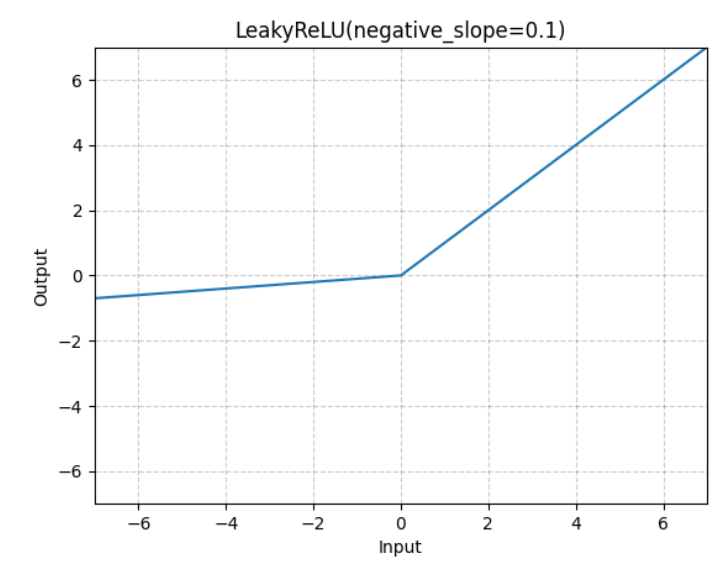

In [ ]:
# get the model and move it to the GPU
model = one_hidden_layer(1, hidden_size, 1, dr) #architecture
model.to(device=device)                   #move the architecture to the GPU, if available

# compute the number of parameters in the model
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

**Note**: the number of parameters for this simple NN is determined by the number of input, hidden neurons, output:

\begin{equation}
    N_{\rm p} =(N_{\rm input}+1)×N_{\rm hidden}+(N_{\rm hidden}+1)×N_{\rm ouput}
\end{equation}

where the +1 accounts for the bias term associated with each layer.

In [ ]:
# We can more easily create a multilayer model with nn.Sequential

model = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1))

#move it to the GPU
model.to(device=device)                   #move the architecture to the GPU, if available

# compute the number of parameters in the model
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

### Define the loss function and the optimazier

In [ ]:
loss_func = nn.MSELoss()  #loss function. In this case MSE (mean squared error)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=wd)

In [ ]:
start = time.time()

train_value=np.zeros(epochs)
valid_value=np.zeros(epochs)

min_valid_loss=min_valid_loss_param

# scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size_lr, gamma=0.5) # update the learning rate after step_size
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience,
                                           min_lr= 1.0e-6, verbose=True) # update the learning rate after patience-stesp if the loss function does not improve
epoch_best_model = 0

# do a loop over all epochs
for epoch in range(epochs):

    # do training
    train_loss, points = 0.0, 0
    model.train()  #set this when training. Some architecture pieces, e.g. dropout behave differently
    for x_train, y_train in train_loader:  #do a loop over all elements in the training set

        # get the size of the batch
        bs = x_train.shape[0]

        # move data to GPU
        y_train = y_train.to(device)
        x_train   = x_train.to(device)

        # compute the value predicted by the network
        y_pred  = model(x_train)

        # compute loss
        loss = loss_func(y_pred, y_train)

        # compute cumulative loss and number of examples used
        train_loss += (loss.item())*bs
        points     += bs

        # zero gradients and do backpropagation. This is the magic!
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # get the average training loss
    train_loss /= points
    train_value[epoch]=train_loss


    # do validation
    valid_loss, points = 0.0, 0
    model.eval()   #set this for validation and testing. Some architecture pieces, e.g. dropout behave differently
    for x_val, y_val in valid_loader: # do a loop over all elements in the validation set
        with torch.no_grad():   #put this for validation/testing, so save memory and be more efficient. It tells to dont save gradients.

            # get the size of the batch
            bs = x_val.shape[0]

            # move data to the GPU
            y_val = y_val.to(device)
            x_val   = x_val.to(device)

            # compute prediction by the network
            y_pred = model(x_val)

            # compute cumulative loss and number of examples used
            valid_loss += (loss_func(y_pred, y_val).item())*bs
            points     += bs

    # get the average validation loss
    valid_loss /= points
    valid_value[epoch]=valid_loss

    scheduler.step(valid_loss) # check the loss function and update the lr

    # save model if it has a lower validation loss
    print(f'epoch:{epoch}, valid loss: {valid_loss:.4f}', end='')
    if valid_loss<min_valid_loss:
        torch.save(model.state_dict(), f_model)
        min_valid_loss = valid_loss
        epoch_best_model=epoch
        print(' (best-model)')
    else:
        print('')

    if epoch - epoch_best_model > stop_criterion:
        print ('Training stop at epoch:',epoch,' because the best model does not imporved after ',stop_criterion,' epochs')
        break


stop = time.time()
print('Time taken (seconds):', "{:.4f}".format(stop-start))

In [ ]:
epoche=np.arange(epochs)

plt.plot(epoche,train_value,label='train loss')
plt.plot(epoche,valid_value,ls='--',label='validation loss')

plt.xlabel("Epoch", fontsize=24)
plt.ylabel("$\mathcal{L}$", fontsize=24)
plt.legend()
plt.loglog()

### Let's test the best model

In [ ]:
# get the test data
test_loader = create_dataset('test', X_samp, y_samp, batch_size, seed) #test data

# load the best-model and move it to the GPU
model.load_state_dict(torch.load(f_model))
model.to(device=device)

# define arraies where to store stuff

x_values=np.zeros((int(X_samp.shape[0]*0.15),1), dtype=np.float32)
y_true = np.zeros((int(y_samp.shape[0]*0.15),1), dtype=np.float32)
y_NN = np.zeros((int(y_samp.shape[0]*0.15),1), dtype=np.float32)

# loop over the different batches and get the prediction
offset = 0
test_loss, points = 0.0, 0
model.eval()

counter=0
for x_test, y_test in test_loader:
    with torch.no_grad():

        bs=x_test.shape[0]

        # move data to GPU
        x_test   = x_test.to(device)
        y_test = y_test.to(device)

        # make prediction using network
        y_pred = model(x_test)

        # Store predictions and true parameter values
        # Need to move the array to cpu() and make it numpy()
        # print(y_true.shape,y_test.cpu().numpy().shape,y_test.cpu().numpy())
        # print(y_NN.shape,y_pred.cpu().numpy().shape,y_pred.cpu().numpy())
        x_values[counter:counter+bs,:]=x_test
        y_true[counter:counter+bs,:]= y_test.cpu().numpy()
        y_NN[counter:counter+bs,:]= y_pred.cpu().numpy()


        # compute cumulative loss and number of examples used
        test_loss += (loss_func(y_pred, y_test).item())*x_test.shape[0]
        points += x_test.shape[0]

        counter += bs

# get the average validation loss
test_loss /= points

print('test loss = %.3e'%test_loss)

In [ ]:
# Rescale the parameters back to the original values
x_values= x_values*(np.max(X_samp)-np.min(X_samp))+np.min(X_samp)

std = np.std(y_samp)
mean = np.mean(y_samp)
y_true = std*y_true + mean
y_NN = std*y_NN + mean

In [ ]:
# plot the prediction versus the true values
plt.scatter(x_values,y_true,c='k',alpha=0.2,label='Observation')
plt.scatter(x_values,y_NN,c='r',marker='x',label='Predicted')
plt.plot(X, y, lw=3, color='k', label="Expected signal",zorder=1)

plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()

### Q: How can we improve the fit?

**Try to increase the number of epochs**

**Try to increase the number of hidden neurons by a factor of 10 and 100**

**Try to implement and use a NN with 2 hidden layers**

In [ ]:
# We can more easily create a multilayer model with nn.Sequential

model = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1))

#move it to the GPU
model.to(device=device)                   #move the architecture to the GPU, if available

# compute the number of parameters in the model
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

### Predict mean and scatter

Our previous prediction doesn't account for the scatter around the expected values. Let's try to define our own loss function to predict also the error on the prediction

In [ ]:
seed           = 1                         #random seed to shuffle data before splitting into training, validation and testing
min_valid_loss_param = 1e10                       #set this to a large number. Used to later as threshold to save trained model
batch_size     = 32                        #number of elements each batch contains. Hyper-parameter
lr             = 1e-4                      #value of the learning rate. Hyper-parameter
wd             = 0.0                       #value of the weight decay. Hyper-parameter
dr             = 0.2                       #dropout rate. Hyper-parameter
epochs         = 5000                       # max number of epochs to train the network. Hyper-parameter
patience       = 100                        # Number of epochs without improving the loss function to wait before updating the learning rate
stop_criterion = 200                        # Number of epochs without improving the loss function to wait before stopping the training
hidden_size    = 100                       #size of hidden layer (see nn.Linear)

f_model = 'best_model.pt'                  # Where to save the trained model

In [ ]:
model = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2)) # now we output 2 values the mean and the std

#move it to the GPU
model.to(device=device)                   #move the architecture to the GPU, if available

# compute the number of parameters in the model
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

# get the data for training and validation
train_loader = create_dataset('train', X_samp, y_samp, batch_size, seed) #training data
valid_loader = create_dataset('valid', X_samp, y_samp, batch_size, seed) #validation data

In [ ]:
class loss_function(nn.Module):
    def __init__(self):
        super(loss_function, self).__init__()
    def forward(self, y_sig_predicted,y_training):
        # return torch.sum((y_training[:,0]-y_predicted)**2.+((y_training[:,0]-y_predicted)**2. - sigma_predicted**2.)**2.)  # From https://arxiv.org/abs/2009.08459
        return torch.log(torch.sum((y_training[:,0]-y_sig_predicted[:,0])**2)) + torch.log(torch.sum(((y_training[:,0]-y_sig_predicted[:,0])**2. - y_sig_predicted[:,1]**2.)**2.))  # From https://arxiv.org/pdf/2109.10915.pdf

loss_func = loss_function()

optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=wd)


In [ ]:
# get the data for training and validation
train_loader = create_dataset('train', X_samp, y_samp, batch_size, seed) #training data
valid_loader = create_dataset('valid', X_samp, y_samp, batch_size, seed) #validation data

In [ ]:
start = time.time()

train_value=np.zeros(epochs)
valid_value=np.zeros(epochs)

min_valid_loss=min_valid_loss_param

# scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size_lr, gamma=0.5) # update the learning rate after step_size
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience,
                                           min_lr= 1.0e-6, verbose=True) # update the learning rate after patience-stesp if the loss function does not improve
epoch_best_model = 0


# do a loop over all epochs
for epoch in range(epochs):

    # do training
    train_loss, points = 0.0, 0
    model.train()  #set this when training. Some architecture pieces, e.g. dropout behave differently
    for x_train, y_train in train_loader:  #do a loop over all elements in the training set

        # get the size of the batch
        bs = x_train.shape[0]

        # move data to GPU
        y_train = y_train.to(device)
        x_train   = x_train.to(device)

        # compute the value predicted by the network
        y_sig_pred  = model(x_train)

        y_pred= y_sig_pred[:,0]
        sig_pred= y_sig_pred[:,1]


        # compute loss
        loss = loss_func(y_sig_pred, y_train)

        # compute cumulative loss and number of examples used
        train_loss += (loss.item())
        points     += bs

        # zero gradients and do backpropagation. This is the magic!
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    # get the average training loss
    train_loss /= points
    train_value[epoch]=train_loss


    # do validation
    valid_loss, points = 0.0, 0
    model.eval()   #set this for validation and testing. Some architecture pieces, e.g. dropout behave differently
    for x_val, y_val in valid_loader: # do a loop over all elements in the validation set
        with torch.no_grad():   #put this for validation/testing, so save memory and be more efficient. It tells to dont save gradients.

            # get the size of the batch
            bs = x_val.shape[0]

            # move data to the GPU
            y_val = y_val.to(device)
            x_val   = x_val.to(device)

            # compute prediction by the network
            y_sig_pred  = model(x_val)

            # y_pred= y_sig_pred[:,0]
            # sig_pred= y_sig_pred[:,1]

            # compute cumulative loss and number of examples used
            valid_loss += (loss_func(y_sig_pred, y_val).item())
            points     += bs

    # get the average validation loss
    valid_loss /= points
    valid_value[epoch]=valid_loss

    scheduler.step(valid_loss) # check the loss function and update the lr

    # save model if it has a lower validation loss
    print(f'epoch:{epoch}, valid loss: {valid_loss:.4f}', end='')
    if valid_loss<min_valid_loss:
        torch.save(model.state_dict(), f_model)
        min_valid_loss = valid_loss
        epoch_best_model=epoch
        print(' (best-model)')
    else:
        print('')

    if epoch - epoch_best_model > stop_criterion:
        print ('Training stop at epoch:',epoch,' because the best model does not imporved after ',stop_criterion,' epochs')
        break

stop = time.time()
print('Time taken (seconds):', "{:.4f}".format(stop-start))

In [ ]:
epoche=np.arange(epoch_best_model)

plt.plot(epoche,train_value[:epoch_best_model],label='training')
plt.plot(epoche,valid_value[:epoch_best_model],ls='--',label='validation')

plt.legend()
plt.xlabel("Epoch", fontsize=24)
plt.ylabel("$\mathcal{L}$", fontsize=24)
# plt.loglog(nonpositive='clip')

### Let's test the best model

In [ ]:
# get the test data
test_loader = create_dataset('test', X_samp, y_samp, batch_size, seed) #test data

# load the best-model and move it to the GPU
model.load_state_dict(torch.load(f_model))
model.to(device=device)

# define arraies where to store stuff

x_values=np.zeros((int(X_samp.shape[0]*0.15),1), dtype=np.float32)
y_true = np.zeros((int(y_samp.shape[0]*0.15),1), dtype=np.float32)
y_sig_NN = np.zeros((int(y_samp.shape[0]*0.15),2), dtype=np.float32)

# loop over the different batches and get the prediction
offset = 0
test_loss, points = 0.0, 0
model.eval()

counter=0
for x_test, y_test in test_loader:
    with torch.no_grad():

        bs=x_test.shape[0]

        # move data to GPU
        x_test   = x_test.to(device)
        y_test = y_test.to(device)

        # make prediction using network
        y_sig_pred  = model(x_test)

        y_pred= y_sig_pred[:,0]
        sig_pred= y_sig_pred[:,1]

        # Store predictions and true parameter values
        # Need to move the array to cpu() and make it numpy()
        # print(y_true.shape,y_test.cpu().numpy().shape,y_test.cpu().numpy())
        # print(y_NN.shape,y_pred.cpu().numpy().shape,y_pred.cpu().numpy())
        x_values[counter:counter+bs,:]=x_test
        y_true[counter:counter+bs,:]= y_test.cpu().numpy()
        y_sig_NN[counter:counter+bs,:]= y_sig_pred.cpu().numpy()

        # compute cumulative loss and number of examples used
        test_loss += (loss_func(y_sig_pred, y_test))
        points += x_test.shape[0]

        counter += bs

# get the average validation loss
test_loss /= points

print('test loss = %.3e'%test_loss)

In [ ]:
# Rescale the parameters back to the original values
x_values= x_values*(np.max(X_samp)-np.min(X_samp))+np.min(X_samp)
# y_true= y_true*(np.max(y_samp)-np.min(y_samp))+np.min(y_samp)
# y_sig_NN[:,0]= y_sig_NN[:,0]*(np.max(y_samp)-np.min(y_samp))+np.min(y_samp)
# y_sig_NN[:,1]= y_sig_NN[:,1]*(np.max(y_samp)-np.min(y_samp))

std = np.std(y_samp)
mean = np.mean(y_samp)
y_true = std*y_true + mean
y_sig_NN[:,0] = std*y_sig_NN[:,0] + mean
y_sig_NN[:,1]= std*y_sig_NN[:,1]

In [ ]:
# plot the prediction versus the true values
plt.scatter(x_values,y_true,c='k',alpha=0.9,label='Test data')
plt.scatter(x_values,y_sig_NN[:,0],c='r',marker='x',label='Predicted')

x_sorted=np.sort(x_values[:,0])
y_NN_sorted=y_sig_NN[x_values[:,0].argsort(),0]
sig_NN_sorted=y_sig_NN[x_values[:,0].argsort(),1]

# print(y_NN_sorted,sig_NN_sorted)

# plt.fill_between(x_values[:,0],y_sig_NN[:,0]-y_sig_NN[:,1],y_sig_NN[:,0]+y_sig_NN[:,1],alpha=0.5)
plt.fill_between(x_sorted,y_NN_sorted-sig_NN_sorted,y_NN_sorted+sig_NN_sorted,alpha=0.5,color='C0')
plt.fill_between(x_sorted,y_NN_sorted-2.*sig_NN_sorted,y_NN_sorted+2.*sig_NN_sorted,alpha=0.2,color='C0')

plt.plot(X, y, lw=1, color='k', label="Expected signal",zorder=1)
# plt.fill_between(X[:,0] , y-0.3,y+0.3, color='gray', alpha=0.5)
plt.fill_between(X[:,0] , y-2.*0.3,y+2.*0.3, alpha=0.5,  hatch='/', facecolor='w', edgecolor='k',zorder=0)

plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()

### Exercise: Build and train a NN to emaulte the following function $y(x_1,x_2)$

In [ ]:
def target_generator(X1,X2, add_noise=False):
    n_sin=np.random.randint(5,10)
    freq=np.random.uniform(1.,10.,size=n_sin)
    phase=np.random.uniform(0.,2.*np.pi,size=n_sin)
    expo=np.random.randint(1,3)
    expected = np.sum(np.sin(freq * X1 + phase),axis=1).reshape(-1, 1)+X2**expo
    print(expected.shape,X1.shape,X2.shape,np.sum(np.sin(freq * X1 + phase),axis=1).shape,(X2**expo).shape)
    if add_noise:
        rng = np.random.RandomState(1)
        observed = expected+rng.normal(0, 0.5, size=expected.shape)
    return expected.squeeze(),observed.squeeze()

In [ ]:
n_train=1000
rng = np.random.RandomState(0)
X1_samp = rng.uniform(0, 5, size=n_train).reshape(-1, 1)
X2_samp = rng.uniform(0, 5, size=n_train).reshape(-1, 1)
y, y_samp = target_generator(X1_samp,X2_samp, add_noise=True)

X_samp=np.hstack((X1_samp,X2_samp))
print(X1_samp.shape,X2_samp.shape,X_samp.shape,y.shape)

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(X1_samp[:,0],X2_samp[:,0],y_samp)

ax.set_xlabel('X1 Label')
ax.set_ylabel('X2 Label')
ax.set_zlabel('Y Label')

In [ ]:
seed           = 1                         #random seed to shuffle data before splitting into training, validation and testing
min_valid_loss_param = 1e10                       #set this to a large number. Used to later as threshold to save trained model
batch_size     = 32                        #number of elements each batch contains. Hyper-parameter
lr             = 1e-2                      #value of the learning rate. Hyper-parameter
wd             = 0.0                       #value of the weight decay. Hyper-parameter
dr             = 0.2                       #dropout rate. Hyper-parameter
epochs         = 5000                       # max number of epochs to train the network. Hyper-parameter
patience       = 100                        # Number of epochs without improving the loss function to wait before updating the learning rate
stop_criterion = 200                        # Number of epochs without improving the loss function to wait before stopping the training
hidden_size    = 100                       #size of hidden layer (see nn.Linear)

f_model = 'best_model.pt'                  # Where to save the trained model

In [ ]:
def create_dataset(mode, x, y, batch_size, seed):

    # create the class with the dataset
    data_set = make_dataset(mode, x, y, seed)

    # create the data loader
    return DataLoader(dataset=data_set, batch_size=batch_size, shuffle=True)

In [ ]:
# This class creates the dataset
class make_dataset():

    def __init__(self, mode, x, y, seed):

        # # Normalize the value of the input
        min_x = np.min(x, axis=0)
        max_x = np.max(x, axis=0)
        x     = (x - min_x)/(max_x - min_x)

        # # Standardize the value of the ouput
        mean = np.mean(y, axis=0)
        std  = np.std(y,  axis=0)
        y = (y - mean)/std


        # get the number of training data
        n_training = x.shape[0]

        # get the size and offset depending on the type of dataset
        if   mode=='train':
            size, offset = int(n_training*0.70), int(n_training*0.00)
        elif mode=='valid':
            size, offset = int(n_training*0.15), int(n_training*0.70)
        elif mode=='test':
            size, offset = int(n_training*0.15), int(n_training*0.85)
        elif mode=='all':
            size, offset = int(n_training*1.00), int(n_training*0.00)
        else:    raise Exception('Wrong name!')

        # define size, input and output arrays containing the data
        self.size   = size
        self.input  = torch.zeros((size,2), dtype=torch.float) #array with x values
        self.output = torch.zeros((size,1),    dtype=torch.float) #array with y values

        # randomly shuffle the data. Instead of 0 1 2 3...999 have a
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        indexes = np.arange(n_training)
        np.random.shuffle(indexes)
        indexes = indexes[offset:offset+size] #select indexes of the mode

        # get the corresponding x and y values
        self.input  = torch.tensor(x[indexes], dtype=torch.float32)
        self.output = torch.tensor(y[indexes], dtype=torch.float32)
        self.output = self.output.unsqueeze(1)

        # self.output = self.output.view(self.output.shape[0],1) # same as unsqueeze

    # This protocol returns the size of the dataset
    def __len__(self):
        return self.size

    # This protocol returns
    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

In [ ]:
# get the data for training and validation
train_loader = create_dataset('train', X_samp, y_samp, batch_size, seed) #training data
valid_loader = create_dataset('valid', X_samp, y_samp, batch_size, seed) #validation data

In [ ]:
# We can more easily create a multilayer model with nn.Sequential

model = nn.Sequential(
            nn.Linear(2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1))

#move it to the GPU
model.to(device=device)                   #move the architecture to the GPU, if available

# compute the number of parameters in the model
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

In [ ]:
loss_func = nn.MSELoss()  #loss function. In this case MSE (mean squared error)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=wd)

In [ ]:
start = time.time()

train_value=np.zeros(epochs)
valid_value=np.zeros(epochs)

min_valid_loss=min_valid_loss_param

# scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size_lr, gamma=0.5) # update the learning rate after step_size
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience,
                                           min_lr= 1.0e-6, verbose=True) # update the learning rate after patience-stesp if the loss function does not improve
epoch_best_model = 0

# do a loop over all epochs
for epoch in range(epochs):

    # do training
    train_loss, points = 0.0, 0
    model.train()  #set this when training. Some architecture pieces, e.g. dropout behave differently
    for x_train, y_train in train_loader:  #do a loop over all elements in the training set

        # get the size of the batch
        bs = x_train.shape[0]

        # move data to GPU
        y_train = y_train.to(device)
        x_train   = x_train.to(device)

        # compute the value predicted by the network
        y_pred  = model(x_train)

        # compute loss
        loss = loss_func(y_pred, y_train)

        # compute cumulative loss and number of examples used
        train_loss += (loss.item())*bs
        points     += bs

        # zero gradients and do backpropagation. This is the magic!
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # get the average training loss
    train_loss /= points
    train_value[epoch]=train_loss


    # do validation
    valid_loss, points = 0.0, 0
    model.eval()   #set this for validation and testing. Some architecture pieces, e.g. dropout behave differently
    for x_val, y_val in valid_loader: # do a loop over all elements in the validation set
        with torch.no_grad():   #put this for validation/testing, so save memory and be more efficient. It tells to dont save gradients.

            # get the size of the batch
            bs = x_val.shape[0]

            # move data to the GPU
            y_val = y_val.to(device)
            x_val   = x_val.to(device)

            # compute prediction by the network
            y_pred = model(x_val)

            # compute cumulative loss and number of examples used
            valid_loss += (loss_func(y_pred, y_val).item())*bs
            points     += bs

    # get the average validation loss
    valid_loss /= points
    valid_value[epoch]=valid_loss

    scheduler.step(valid_loss) # check the loss function and update the lr

    # save model if it has a lower validation loss
    print(f'epoch:{epoch}, valid loss: {valid_loss:.4f}', end='')
    if valid_loss<min_valid_loss:
        torch.save(model.state_dict(), f_model)
        min_valid_loss = valid_loss
        epoch_best_model=epoch
        print(' (best-model)')
    else:
        print('')

    if epoch - epoch_best_model > stop_criterion:
        print ('Training stop at epoch:',epoch,' because the best model does not imporved after ',stop_criterion,' epochs')
        break


stop = time.time()
print('Time taken (seconds):', "{:.4f}".format(stop-start))

In [ ]:
epoche=np.arange(epochs)

plt.plot(epoche,train_value,label='train loss')
plt.plot(epoche,valid_value,ls='--',label='validation loss')

plt.xlabel("Epoch", fontsize=24)
plt.ylabel("$\mathcal{L}$", fontsize=24)
plt.legend()
plt.loglog()

In [ ]:
# get the test data
test_loader = create_dataset('test', X_samp, y_samp, batch_size, seed) #test data

# load the best-model and move it to the GPU
model.load_state_dict(torch.load(f_model))
model.to(device=device)

# define arraies where to store stuff

x_values=np.zeros((int(X_samp.shape[0]*0.15),2), dtype=np.float32)
y_true = np.zeros((int(y_samp.shape[0]*0.15),1), dtype=np.float32)
y_NN = np.zeros((int(y_samp.shape[0]*0.15),1), dtype=np.float32)

# loop over the different batches and get the prediction
offset = 0
test_loss, points = 0.0, 0
model.eval()

counter=0
for x_test, y_test in test_loader:
    with torch.no_grad():

        bs=x_test.shape[0]

        # move data to GPU
        x_test   = x_test.to(device)
        y_test = y_test.to(device)

        # make prediction using network
        y_pred = model(x_test)

        # Store predictions and true parameter values
        # Need to move the array to cpu() and make it numpy()
        # print(y_true.shape,y_test.cpu().numpy().shape,y_test.cpu().numpy())
        # print(y_NN.shape,y_pred.cpu().numpy().shape,y_pred.cpu().numpy())
        x_values[counter:counter+bs,:]=x_test
        y_true[counter:counter+bs,:]= y_test.cpu().numpy()
        y_NN[counter:counter+bs,:]= y_pred.cpu().numpy()


        # compute cumulative loss and number of examples used
        test_loss += (loss_func(y_pred, y_test).item())*x_test.shape[0]
        points += x_test.shape[0]

        counter += bs

# get the average validation loss
test_loss /= points

print('test loss = %.3e'%test_loss)

In [ ]:
# Rescale the parameters back to the original values
x_values= x_values*(np.max(X_samp, axis=0)-np.min(X_samp, axis=0))+np.min(X_samp, axis=0)

std = np.std(y_samp)
mean = np.mean(y_samp)
y_true = std*y_true + mean
y_NN = std*y_NN + mean

In [ ]:
# plot the prediction versus the true values
plt.scatter(x_values[:,0],y_true,c='k',alpha=0.2,label='Observation')
plt.scatter(x_values[:,0],y_NN,c='r',marker='x',label='Predicted')

plt.xlabel("$x_1$")
plt.ylabel("$y$")
plt.legend()

In [ ]:
# plot the prediction versus the true values
plt.scatter(x_values[:,1],y_true,c='k',alpha=0.2,label='Observation')
plt.scatter(x_values[:,1],y_NN,c='r',marker='x',label='Predicted')

plt.xlabel("$x_1$")
plt.ylabel("$y$")
plt.legend()

Let's find the best hyper-parameters to train the NN

#### Optuna Optimizer: https://towardsdatascience.com/hyperparameter-tuning-of-neural-networks-with-optuna-and-pytorch-22e179efc837

#### RayTune Optimizer: https://docs.ray.io/en/latest/tune/index.html https://stackoverflow.com/questions/44260217/hyperparameter-optimization-for-pytorch-model

In [ ]:
def target_generator(X, add_noise=False):
    target = X * np.sin(3 * X)
    if add_noise:
        rng = np.random.RandomState(1)
        target += rng.normal(0, 0.3, size=target.shape)
    return target.squeeze()

In [ ]:
X = np.linspace(0, 5, num=1000).reshape(-1, 1)
y = target_generator(X, add_noise=False)

n_train=1000
rng = np.random.RandomState(0)
X_samp = rng.uniform(0, 5, size=n_train).reshape(-1, 1)
y_samp = target_generator(X_samp, add_noise=True)

In [ ]:
plt.plot(X, y, label="Expected signal")
plt.scatter(
    x=X_samp[:, 0],
    y=y_samp,
    color="black",
    alpha=0.4,
    label="Observations",
)
plt.legend()
plt.xlabel("X")
plt.ylabel("y")

In [ ]:
def create_dataset(mode, x, y, batch_size, seed):

    # create the class with the dataset
    data_set = make_dataset(mode, x, y, seed)

    # create the data loader
    return DataLoader(dataset=data_set, batch_size=batch_size, shuffle=True)

In [ ]:
# This class creates the dataset
class make_dataset():

    def __init__(self, mode, x, y, seed):

        # # Normalize the value of the input
        min_x = np.min(x, axis=0)
        max_x = np.max(x, axis=0)
        x     = (x - min_x)/(max_x - min_x)

        # # Standardize the value of the ouput
        mean = np.mean(y, axis=0)
        std  = np.std(y,  axis=0)
        y = (y - mean)/std


        # get the number of training data
        n_training = x.shape[0]

        # get the size and offset depending on the type of dataset
        if   mode=='train':
            size, offset = int(n_training*0.70), int(n_training*0.00)
        elif mode=='valid':
            size, offset = int(n_training*0.15), int(n_training*0.70)
        elif mode=='test':
            size, offset = int(n_training*0.15), int(n_training*0.85)
        elif mode=='all':
            size, offset = int(n_training*1.00), int(n_training*0.00)
        else:    raise Exception('Wrong name!')

        # define size, input and output arrays containing the data
        self.size   = size
        self.input  = torch.zeros((size,1), dtype=torch.float) #array with x values
        self.output = torch.zeros((size,1),    dtype=torch.float) #array with y values

        # randomly shuffle the data. Instead of 0 1 2 3...999 have a
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        indexes = np.arange(n_training)
        np.random.shuffle(indexes)
        indexes = indexes[offset:offset+size] #select indexes of the mode

        # get the corresponding x and y values
        self.input  = torch.tensor(x[indexes], dtype=torch.float32)
        self.output = torch.tensor(y[indexes], dtype=torch.float32)
        self.output = self.output.unsqueeze(1)

        # self.output = self.output.view(self.output.shape[0],1) # same as unsqueeze

    # This protocol returns the size of the dataset
    def __len__(self):
        return self.size

    # This protocol returns
    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

In [ ]:
# get the data for training and validation
train_loader = create_dataset('train', X_samp, y_samp, batch_size, seed) #training data
valid_loader = create_dataset('valid', X_samp, y_samp, batch_size, seed) #validation data

In [ ]:
!pip install optuna
import optuna

In [ ]:
# Build neural network model
def build_model(params):

    in_features = 1
    out_features = 2

    return nn.Sequential(

        nn.Linear(in_features, params['hidden_size']),
        nn.LeakyReLU(),
        nn.Linear(params['hidden_size'], out_features),
        nn.LeakyReLU()
    )

# From https://arxiv.org/pdf/2109.10915.pdf
def loss_func(y_predicted, y_training, sigma_predicted):
        return torch.log(torch.sum((y_training[:,0]-y_predicted)**2)) + torch.log(torch.sum(((y_training[:,0]-y_predicted)**2. - sigma_predicted**2.)**2.))

# Train and evaluate the loss of neural network model
def train_and_evaluate(param, model):
    # get the data for training and validation
    train_loader = create_dataset('train', X_samp, y_samp, batch_size, seed) #training data
    valid_loader = create_dataset('valid', X_samp, y_samp, batch_size, seed) #validation data

    optimizer = torch.optim.Adam(model.parameters(), lr=param['learning_rate'], betas=(0.5, 0.999), weight_decay=wd)

    epochs=param['epochs']

    min_valid_loss=min_valid_loss_param

    # do a loop over all epochs
    for epoch in range(epochs):

        # do training
        train_loss, points = 0.0, 0
        model.train()  #set this when training. Some architecture pieces, e.g. dropout behave differently
        for x_train, y_train in train_loader:  #do a loop over all elements in the training set

            # get the size of the batch
            bs = x_train.shape[0]

            # move data to GPU
            y_train = y_train.to(device)
            x_train   = x_train.to(device)

            # compute the value predicted by the network
            y_sig_pred  = model(x_train)

            # compute loss
            loss = loss_func(y_sig_pred[:,0], y_train,y_sig_pred[:,1])

            # compute cumulative loss and number of examples used
            train_loss += (loss.item())#*bs
            points     += bs

            # zero gradients and do backpropagation. This is the magic!
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # get the average training loss
        train_loss /= points

        # do validation
        valid_loss, points = 0.0, 0
        model.eval()   #set this for validation and testing. Some architecture pieces, e.g. dropout behave differently
        for x_val, y_val in valid_loader: # do a loop over all elements in the validation set
            with torch.no_grad():   #put this for validation/testing, so save memory and be more efficient. It tells to dont save gradients.

                # get the size of the batch
                bs = x_val.shape[0]

                # move data to the GPU
                y_val = y_val.to(device)
                x_val   = x_val.to(device)

                # compute prediction by the network
                y_sig_pred  = model(x_val)

                # compute cumulative loss and number of examples used
                valid_loss += (loss_func(y_sig_pred[:,0], y_val,y_sig_pred[:,1]).item())#*bs
                points     += bs

        # get the average validation loss
        valid_loss /= points

        # save lower loss value
        if valid_loss<min_valid_loss:
            min_valid_loss = valid_loss # non e' detto che l'ultima epoca sia quella con il loss minore, ma io terrei come best model quello, quindi passo questo a optuna

    return min_valid_loss

def objective(trial):

    params = {
              'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
              'epochs': trial.suggest_int("epochs", 100, 500),
              'hidden_size': trial.suggest_int("hidden_size", 50, 100) # number of hidden parameters
              }

    model = build_model(params)

    accuracy = train_and_evaluate(params, model)

    return accuracy

In [ ]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=10)

In [ ]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

If we want to test also the number of layer we can do the following

In [ ]:
def build_model_custom(trial):

    # Suggest the number of layers of neural network model
    n_layers = trial.suggest_int("n_layers", 1, 4)
    layers = []

    in_features = 1
    out_features = 2

    for i in range(n_layers):

        # Suggest the number of units in each layer
        hidden_size = trial.suggest_int("hidden_size", 10, 100) # number of hidden parameters
        # hidden_size = trial.suggest_int("n_units_l{}".format(i), 50, 100)

        layers.append(nn.Linear(in_features, hidden_size))
        layers.append(nn.LeakyReLU())

        in_features = hidden_size

    layers.append(nn.Linear(in_features, out_features))
    layers.append(nn.LeakyReLU())

    return nn.Sequential(*layers)

# Train and evaluate the loss of neural network model
def train_and_evaluate(param, model, trial):
    # get the data for training and validation
    train_loader = create_dataset('train', X_samp, y_samp, batch_size, seed) #training data
    valid_loader = create_dataset('valid', X_samp, y_samp, batch_size, seed) #validation data

    optimizer = torch.optim.Adam(model.parameters(), lr=param['learning_rate'], betas=(0.5, 0.999), weight_decay=wd)

    epochs=param['epochs']

    min_valid_loss=min_valid_loss_param

    # do a loop over all epochs
    for epoch in range(epochs):

        # do training
        train_loss, points = 0.0, 0
        model.train()  #set this when training. Some architecture pieces, e.g. dropout behave differently
        for x_train, y_train in train_loader:  #do a loop over all elements in the training set

            # get the size of the batch
            bs = x_train.shape[0]

            # move data to GPU
            y_train = y_train.to(device)
            x_train   = x_train.to(device)

            # compute the value predicted by the network
            y_sig_pred  = model(x_train)

            # compute loss
            loss = loss_func(y_sig_pred[:,0], y_train,y_sig_pred[:,1])

            # compute cumulative loss and number of examples used
            train_loss += (loss.item())
            points     += bs

            # zero gradients and do backpropagation. This is the magic!
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # get the average training loss
        train_loss /= points

        # do validation
        valid_loss, points = 0.0, 0
        model.eval()   #set this for validation and testing. Some architecture pieces, e.g. dropout behave differently
        for x_val, y_val in valid_loader: # do a loop over all elements in the validation set
            with torch.no_grad():   #put this for validation/testing, so save memory and be more efficient. It tells to dont save gradients.

                # get the size of the batch
                bs = x_val.shape[0]

                # move data to the GPU
                y_val = y_val.to(device)
                x_val   = x_val.to(device)

                # compute prediction by the network
                y_sig_pred  = model(x_val)

                # compute cumulative loss and number of examples used
                valid_loss += (loss_func(y_sig_pred[:,0], y_val,y_sig_pred[:,1]).item())
                points     += bs

        # get the average validation loss
        valid_loss /= points

        # save lower loss value
        if valid_loss<min_valid_loss:
            min_valid_loss = valid_loss # non e' detto che l'ultima epoca sia quella con il loss minore, ma io terrei come best model quello, quindi passo questo a optuna

        trial.report(min_valid_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return min_valid_loss

def objective(trial):

    params = {
              'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
              'epochs': trial.suggest_int("epochs", 100, 500),
              }

    model = build_model_custom(trial)

    accuracy = train_and_evaluate(params, model,trial)

    return accuracy

In [ ]:
# Let's also add a method (prune) to terminate unpromising trials in the early stages of the training process
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.PercentilePruner(80.))
study.optimize(objective, n_trials=30)

In [ ]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

In [ ]:
optuna.visualization.plot_intermediate_values(study)

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_param_importances(study)